In [12]:
import numpy as np                   
import pandas as pd                 
import xgboost as xgb                
import shap #For consistent, signed variable importance measurements

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

%matplotlib inline

np.random.seed(12345)

# Explore and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [13]:
#Import XLS file
path = './data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [14]:
#Assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [15]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [16]:
#Displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specifiy monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `DEFAULT_NEXT_MONTH` is positive, a positive montonic relationship constraint is specified for that variable using `1`. If the correlation is negative, a negative monotonic constraint is specified using `-1`. (Specifying `0` indicates that no constraints should be used.) The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [17]:
#Creates a tuple in which positive correlation values are assigned a 1
#and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

#(-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

# Train XGBoost with monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `DEFAULT_NEXT_MONTH`. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, GBM variable importance is calculated and displayed. GBM variable importance is a global measure of the overall impact of an input variable on the GBM model predictions. Global variable importance values give an indication of the magnitude of a variable's contribution to model predictions for all observations. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [18]:
np.random.seed(12345) #Set random seed for reproducibility
split_ratio = 0.7     #70%/30% train/test split

#Execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


### Train XGBoost GBM classifier with monotonicity constraints
To train an XGBoost classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. 

Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test area under the curve (AUC) statistic fails to increase for 50 iterations.

In [19]:
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

#Used to calibrate predictions to mean of y 
base_y = train[y].mean()

#Tuning parameters
params = {
    'objective': 'binary:logistic',             #Produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        #Base learner will be decision tree
    'eval_metric': 'auc',                       #Stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                #Learning rate
    'subsample': 0.9,                           #Use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    #Use 90% of columns in each decision tree
    'max_depth': 15,                            #Allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    #1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       #Calibrate predictions to mean of y 
    'seed': 12345                               #Set random seed for reproducibility
}

#Watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Train model
xgb_model = xgb.train(params,                   #Set tuning parameters from above                   
                      dtrain,                   #Training data
                      1000,                     #Maximum of 1000 iterations (trees)
                      evals=watchlist,          #Use watchlist for early stopping 
                      early_stopping_rounds=50, #Stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        #Display iteration progress


[14:00:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=12
[0]	train-auc:0.738498	eval-auc:0.73357
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[14:00:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=11
[1]	train-auc:0.773412	eval-auc:0.769393
[14:00:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=11
[2]	train-auc:0.775968	eval-auc:0.772659
[14:00:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=12
[3]	train-auc:0.776642	eval-auc:0.772004
[14:00:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=11
[4]	train-auc:0.777602	eval-auc:0.772722
[14:00:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 

[14:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=12
[52]	train-auc:0.790433	eval-auc:0.780664
[14:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=15
[53]	train-auc:0.790606	eval-auc:0.780639
[14:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=13
[54]	train-auc:0.79077	eval-auc:0.780705
[14:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=15
[55]	train-auc:0.79084	eval-auc:0.780745
[14:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=14
[56]	train-auc:0.790918	eval-auc:0.780774
[14:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=13
[57]	train-auc:0.791024	eval-auc:0.780788
[14:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots

[14:00:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=15
[105]	train-auc:0.794678	eval-auc:0.781093
[14:00:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=15
[106]	train-auc:0.794724	eval-auc:0.781069
[14:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=15
[107]	train-auc:0.794799	eval-auc:0.781025
[14:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=15
[108]	train-auc:0.794827	eval-auc:0.781021
[14:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=15
[109]	train-auc:0.794854	eval-auc:0.781024
[14:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=15
[110]	train-auc:0.794879	eval-auc:0.781005
[14:00:27] src/tree/updater_prune.cc:74: tree pruning end,

### Global Shapley variable importance
By setting pred_contribs=True, XGBoost's predict() function will return Shapley values for each row of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be ploted below to get a more holistic and consisent measurement for the global importance of each input variable. Shapley values are introduced in greater detail in Section 6 below, but for now notice the monotonicity of the input variable contributions displayed in the Shapley summary plot.

In [20]:
#dtest is DMatrix
#shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

### Display Shapley variable importance summary
The variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, PAY_0 is by far the most important variable. As someone's most recent behavior is a very good indicator of future behavior, this checks out.

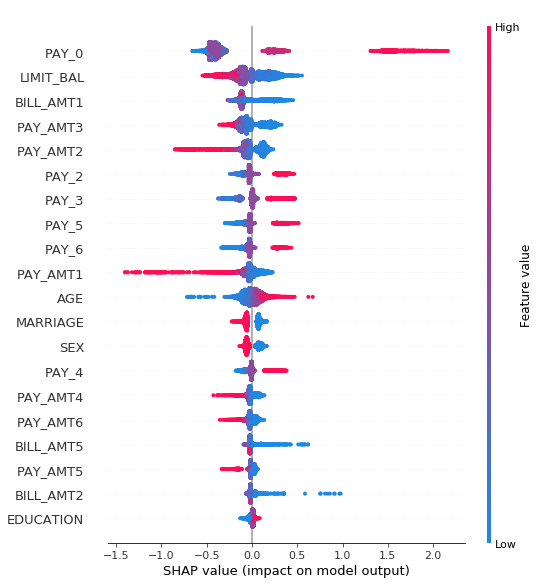

In [21]:
#Plot Shapley variable importance summary 
shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])

# Calculating partial dependence and ICE to validate and explain monotonic behavior

Partial dependence plots are used to view the global, average prediction behavior of a variable under the monotonic model. Partial dependence plots show the average prediction of the monotonic model as a function of specific values of an input variable of interest, indicating how the monotonic GBM predictions change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other input variables. Partial dependence plots enable increased transparency into the monotonic GBM's mechanisms and enable validation and debugging of the monotonic GBM by comparing a variable's average predictions across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in The Elements of Statistical Learning, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the monotonic GBM. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

Because partial dependence and ICE are measured on the same scale, they can be displayed in the same line plot to compare the global, average prediction behavior for the entire model and the local prediction behavior for certain rows of data.

### Function for calculating partial dependence
Since partial dependence and ICE will be calculated for several important variables in the GBM model, it's convenient to have a function doing so. It's probably best to analyze partial dependence and ICE for all variables in a model, but only the top three most important input variables will be investigated here. It's also a good idea to analyze partial dependence and ICE on the test data, or other holdout datasets, to see how the model will perform on new data. This simple function is designed to return partial dependence when it is called for an entire dataset and ICE when it is called for a single row. The bins argument will be used later to calculate ICE values at the same places in an input variable domain that partial dependence is calculated directly below.

In [22]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    #Turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    #Initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    #Cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    #Determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    #Calculate partial dependence  
    #by setting column of interest to constant 
    #and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    #Return input frame to original cached state    
    frame.loc[:, xs] = col_cache
    
    return par_dep_frame

### Calculate partial dependence for the most important input variables in the GBM
The partial dependence for LIMIT_BAL can be seen to decrease as credit balance limits increase. This finding is aligned with expectations that the model predictions will be monotonically decreasing with increasing LIMIT_BAL and parsimonious with well-known business practices in credit lending. Partial dependence for other important values is displayed in plots further below.

In [23]:
par_dep_PAY_0 = par_dep('PAY_0', test[X], xgb_model)         # calculate partial dependence for PAY_0
par_dep_LIMIT_BAL = par_dep('LIMIT_BAL', test[X], xgb_model) # calculate partial dependence for LIMIT_BAL
par_dep_BILL_AMT1 = par_dep('BILL_AMT1', test[X], xgb_model) # calculate partial dependence for BILL_AMT1

#Display partial dependence for LIMIT_BAL
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence
0,10000.0,0.276218
1,59500.0,0.241185
2,109000.0,0.224639
3,158500.0,0.215221
4,208000.0,0.213736
5,257500.0,0.209377
6,307000.0,0.203863
7,356500.0,0.196718
8,406000.0,0.195773
9,455500.0,0.195161


### Helper function for finding percentiles of predictions
ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions (p_DEFAULT_NEXT_MONTH) and the row identifier (ID), respectively.

In [24]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    #Create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    #Find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    #Find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

### Find some percentiles of yhat in the test data
The values for ID that correspond to the maximum, minimum, and deciles of p_DEFAULT_NEXT_MONTH are displayed below. ICE will be calculated for the rows of the test dataset associated with these ID values.

In [25]:
#Merge GBM predictions onto test data# merge  
yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest))], axis=1)
yhat_test = yhat_test.rename(columns={0:'p_DEFAULT_NEXT_MONTH'})

#Find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

#Display percentiles dictionary
#ID values for rows
#from lowest prediction 
#to highest prediction
percentile_dict

{0: 23477,
 99: 20904,
 10: 2949,
 20: 20445,
 30: 13592,
 40: 25431,
 50: 17549,
 60: 7628,
 70: 9441,
 80: 28236,
 90: 24012}

### Calculate ICE curve values
ICE values represent a model's prediction for a row of data while an input variable of interest is varied across its domain. The values of the input variable are chosen to match the values at which partial dependence was calculated earlier, and ICE is calculated for the top three most important variables and for rows at each percentile of the test dataset.

In [26]:
#Retreive bins from original partial dependence calculation

bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])
bins_LIMIT_BAL = list(par_dep_LIMIT_BAL['LIMIT_BAL'])
bins_BILL_AMT1 = list(par_dep_BILL_AMT1['BILL_AMT1'])

#For each percentile in percentile_dict
#create a new column in the par_dep frame 
#representing the ICE curve for that percentile
#and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    #ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                    test[test['ID'] == int(percentile_dict[i])][X],  
                                    xgb_model, 
                                    bins=bins_PAY_0)['partial_dependence']
    
    #ICE curves for LIMIT_BAL across percentiles at bins_LIMIT_BAL intervals
    par_dep_LIMIT_BAL[col_name] = par_dep('LIMIT_BAL', 
                                          test[test['ID'] == int(percentile_dict[i])][X], 
                                          xgb_model, 
                                          bins=bins_LIMIT_BAL)['partial_dependence']
    


    #ICE curves for BILL_AMT1 across percentiles at bins_BILL_AMT1 intervals
    par_dep_BILL_AMT1[col_name] = par_dep('BILL_AMT1', 
                                          test[test['ID'] == int(percentile_dict[i])][X],  
                                          xgb_model, 
                                          bins=bins_BILL_AMT1)['partial_dependence']

### Display partial dependence and ICE for LIMIT_BAL
Partial dependence and ICE values for rows at the minimum, maximum and deciles (0%, 10%, 20%, ..., 90%, 99%) of predictions for  DEFAULT_NEXT_MONTH and at the values of LIMIT_BAL used for partial dependence are shown here. Each column of ICE values will be a curve in the plots below. ICE values represent a prediction for a row of test data, at a percentile of interest noted in the column name above, and setting LIMIT_BAL to the value of LIMIT_BAL at right. Notice that monotonic decreasing prediction behavior for LIMIT_BAL holds at each displayed percentile of predicted DEFAULT_NEXT_MONTH, helping to validate that the trained GBM predictions are monotonic for LIMIT_BAL.

In [27]:
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,10000.0,0.276218,0.006934,0.100023,0.108279,0.144719,0.175377,0.171489,0.255722,0.287452,0.512173,0.603419,0.977758
1,59500.0,0.241185,0.005366,0.090807,0.100336,0.129896,0.165187,0.152312,0.198520,0.240576,0.324775,0.594607,0.961227
2,109000.0,0.224639,0.003345,0.070811,0.086129,0.100557,0.137880,0.112118,0.191669,0.236630,0.324751,0.588344,0.960040
3,158500.0,0.215221,0.002425,0.058176,0.069585,0.091169,0.125413,0.097189,0.186911,0.233670,0.324344,0.573236,0.960033
4,208000.0,0.213736,0.002271,0.057645,0.065743,0.091088,0.123826,0.097157,0.186225,0.232569,0.324174,0.573044,0.953260
5,257500.0,0.209377,0.002197,0.054690,0.061664,0.089395,0.113562,0.095480,0.183069,0.231860,0.323556,0.557954,0.949804
6,307000.0,0.203863,0.001764,0.051817,0.057040,0.082153,0.111933,0.087784,0.176086,0.226148,0.323556,0.554566,0.949390
7,356500.0,0.196718,0.001188,0.046093,0.049150,0.074122,0.100926,0.079559,0.170754,0.224268,0.323535,0.546228,0.949212
8,406000.0,0.195773,0.001179,0.045199,0.048887,0.073226,0.099857,0.078982,0.170203,0.223649,0.323535,0.542047,0.949210
9,455500.0,0.195161,0.001179,0.044154,0.047655,0.071530,0.097568,0.077444,0.170203,0.223649,0.323535,0.541576,0.949210


# Plotting partial dependence and ICE to validate and explain monotonic behavior
Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior. Plots of partial dependence curves overlayed onto ICE curves for several percentiles of predictions for DEFAULT_NEXT_MONTH are used to validate monotonic behavior, describe the GBM model mechanisms, and to compare the most extreme GBM behavior with the average GBM behavior in the test data. Partial dependence and ICE plots are displayed for the three most important variables in the GBM: PAY_0, LIMIT_BAL, and BILL_AMT1.

In [28]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    #Initialize figure and axis
    fig, ax = plt.subplots()
    
    #Plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    #Overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    #Add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

### Partial dependence and ICE plot for LIMIT_BAL¶
The monotonic prediction behavior displayed in the partial dependence, and ICE tables for LIMIT_BAL is also visible in this plot. Monotonic decreasing behavior is evident at every percentile of predictions for DEFAULT_NEXT_MONTH. Most percentiles of predictions show that sharper decreases in probability of default occur when LIMIT_BAL increases just slightly from its lowest values in the test set. However, for the custumers that are most likely to default according to the GBM model, no increase in LIMIT_BAL has a strong impact on probabilitiy of default. As mentioned previously, the displayed relationship between credit balance limits and probablility of default is not uncommon in credit lending.

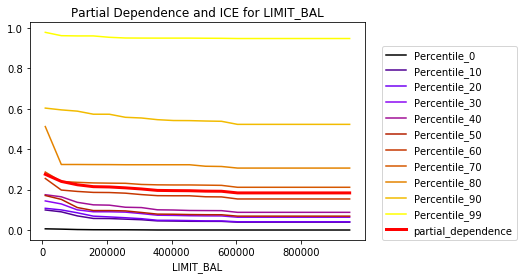

In [29]:
plot_par_dep_ICE('LIMIT_BAL', par_dep_LIMIT_BAL) #Plot partial dependence and ICE for LIMIT_BAL

### Partial dependence and ICE plot for PAY_0
Monotonic increasing prediction behavior for PAY_0 is displayed for all percentiles of model predictions. Predition behavior is different at different deciles, but not abnormal or vastly different from the average prediction behavior represented by the red partial dependence curve. The largest jump in predicted probability appears to occur at PAY_0 = 2, or when a customer becomes two months late on their most recent payment.

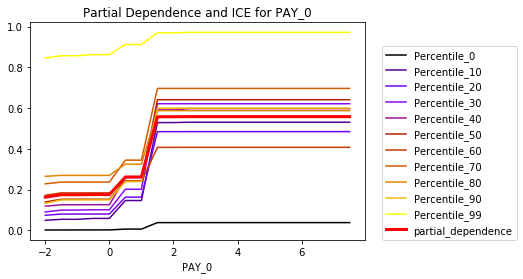

In [30]:
plot_par_dep_ICE('PAY_0', par_dep_PAY_0) #Plot partial dependence and ICE for PAY_0

### Partial dependence and ICE plot for BILL_AMT1
Monotonic decreasing prediction behavior for BILL_AMT1 is also displayed for all percentiles. This mild decrease in probability of default as most recent bill amount increases could be related to wealthier, big-spending customers taking on more debt but also being able to pay it off reliably. Also, customers with negative bills are more likely to default, potentially indicating charge-offs are being recorded as negative bills. In a mission-critical situation, this issue would require more debugging.

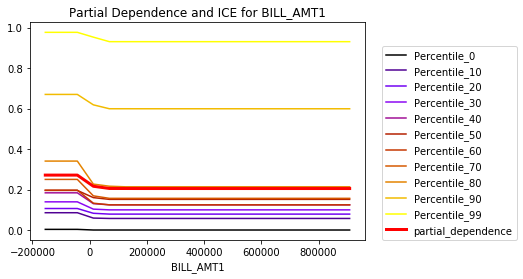

In [31]:
plot_par_dep_ICE('BILL_AMT1', par_dep_BILL_AMT1) #Plot partial dependence and ICE for BILL_AMT1